# Assignment 6, Part D- Extra Credit

## Imports

In [ ]:
import re, time
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.4.1


## TPU or GPU detection
TPUClusterResolver() automatically detects a connected TPU on all Gooogle's
platforms: Colaboratory, AI Platform (ML Engine), Kubernetes, Kaggle, ...

In [ ]:
try: # detect TPUs
  tpu = None
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError: # detect GPUs
  strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
  #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Initializing the TPU system: grpc://10.59.102.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.59.102.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of accelerators:  8


## Configuration
Four images sizes are available for this dataset

1e-05 0.00011223616000000004


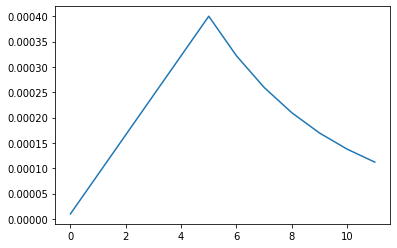

In [ ]:
EPOCHS = 12
IMAGE_SIZE = [331, 331]

FLOWERS_DATASETS = { # available image sizes
    192: 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec',
    224: 'gs://flowers-public/tfrecords-jpeg-224x224/*.tfrec',
    331: 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec',
    512: 'gs://flowers-public/tfrecords-jpeg-512x512/*.tfrec'
}
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # do not change, maps to the labels in the data (folder names)
assert IMAGE_SIZE[0] == IMAGE_SIZE[1], "only square images are supported"
assert IMAGE_SIZE[0] in FLOWERS_DATASETS, "this image size is not supported"


# mixed precision
# On TPU, bfloat16/float32 mixed precision is automatically used in TPU computations.
# Enabling it in Keras also stores relevant variables in bfloat16 format (memory optimization).
# On GPU, specifically V100, mixed precision must be enabled for hardware TensorCores to be used.
# XLA compilation must be enabled for this to work. (On TPU, XLA compilation is the default)
MIXED_PRECISION = False
if MIXED_PRECISION:
    if tpu: 
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: #
        policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
        tf.config.optimizer.set_jit(True) # XLA compilation
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')

# batch and learning rate settings
if strategy.num_replicas_in_sync == 8: # TPU or 8xGPU
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00005 * strategy.num_replicas_in_sync
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
elif strategy.num_replicas_in_sync == 1: # single GPU
    BATCH_SIZE = 16
    VALIDATION_BATCH_SIZE = 16
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.0002
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
else: # TPU pod
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00002 * strategy.num_replicas_in_sync
    rampup_epochs = 7
    sustain_epochs = 0
    exp_decay = .8

def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])

In [ ]:
#@title display utilities [RUN ME]

def dataset_to_numpy_util(dataset, N):
  dataset = dataset.unbatch().batch(N)
  for images, labels in dataset:
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    break;  
  return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  label = np.argmax(label, axis=-1)  # one-hot to class number
  correct_label = np.argmax(correct_label, axis=-1) # one-hot to class number
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_from_dataset(dataset):
  subplot=331
  plt.figure(figsize=(13,13))
  images, labels = dataset_to_numpy_util(dataset, 9)
  for i, image in enumerate(images):
    title = CLASSES[np.argmax(labels[i], axis=-1)]
    subplot = display_one_flower(image, title, subplot)
    if i >= 8:
      break;
              
  #plt.tight_layout() # bug in tight layout in this version of matplotlib
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout() # bug in tight layout in this version of matplotlib
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()
  
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout() # bug in tight layout in this version of matplotlib
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  #ax.set_ylim(0.28,1.05)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Read images and labels from TFRecords

In [ ]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

gcs_pattern = FLOWERS_DATASETS[IMAGE_SIZE[0]]
validation_split = 0.19
filenames = tf.io.gfile.glob(gcs_pattern)
split = len(filenames) - int(len(filenames) * validation_split)
TRAIN_FILENAMES = filenames[:split]
VALID_FILENAMES = filenames[split:]
TRAIN_STEPS = count_data_items(TRAIN_FILENAMES) // BATCH_SIZE
print("TRAINING IMAGES: ", count_data_items(TRAIN_FILENAMES), ", STEPS PER EPOCH: ", TRAIN_STEPS)
print("VALIDATION IMAGES: ", count_data_items(VALID_FILENAMES))
        
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    class_label = tf.cast(example['class'], tf.int32)
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class
    
def force_image_sizes(dataset, image_size):
    # explicit size will be needed for TPU
    reshape_images = lambda image, label: (tf.reshape(image, [*image_size, 3]), label)
    dataset = dataset.map(reshape_images, num_parallel_calls=AUTO)
    return dataset

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, use "interleave(tf.data.TFRecordDataset, ...)"
    # to read from multiple TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.

    opt = tf.data.Options()
    opt.experimental_deterministic = False

    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.with_options(opt)
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    dataset = force_image_sizes(dataset, IMAGE_SIZE)
    return dataset

def data_augment(image, one_hot_class):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, one_hot_class
    
# For experts: fine adjustments of tf.data.Dataset distribution behavior:

# Replicating a datset with state (even random number generator state) does not replicate the
# state and changes the behavior of the dataset. If the state is just the RNG state, it usually
# does not matter but this behavior can be adjusted with tf.data.experimental.ExternalStatePolicy:
#  WARN = 0   (this is the default in Tensorflow outside of Keras)
#  IGNORE = 1 (this is the default in Keras)
#  FAIL = 2

# On TPU pods, the dataset API attempts to shard the dataset across individual TPUs at the file
# level so that TPUs only load the data they will actually train on. This requires more data files 
# than TPUs in the pod. (ex: TPU v3-32 pod = 4 TPUs => dataset must have at least 4 files)
# An error will occur if there are not enough data files. File-level sharding can be disabled:
#  opt = tf.data.Options()
#  opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
#  dataset = dataset.with_options(opt)
   

def get_training_dataset():
    dataset = load_dataset(TRAIN_FILENAMES)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset():
    dataset = load_dataset(VALID_FILENAMES)
    dataset = dataset.batch(VALIDATION_BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    
    # needed for TPU 32-core pod: the test dataset has only 3 files but there are 4 TPUs. FILE sharding policy must be disabled.
    opt = tf.data.Options()
    opt.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    dataset = dataset.with_options(opt)
    
    return dataset


TRAINING IMAGES:  2990 , STEPS PER EPOCH:  23
VALIDATION IMAGES:  680


## training and validation datasets

In [ ]:
training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

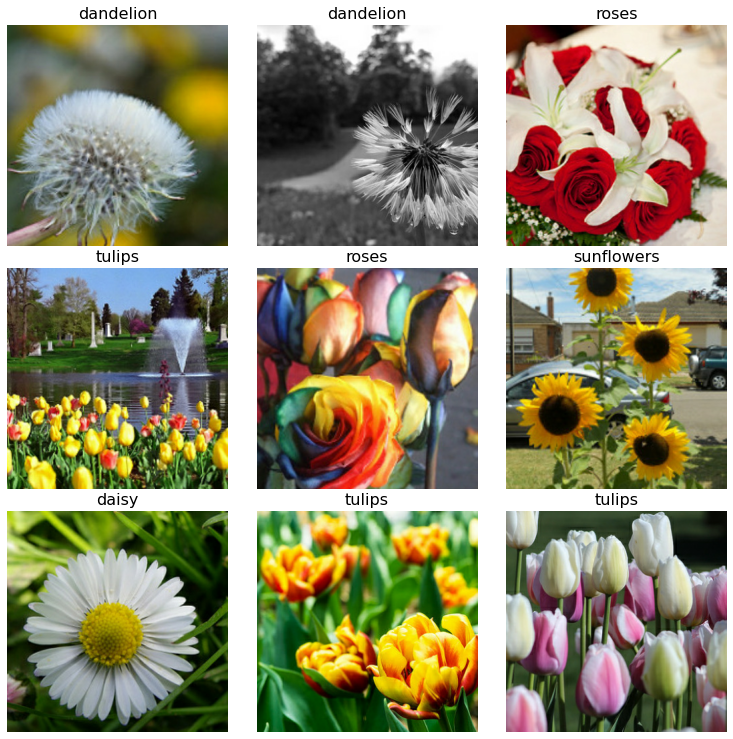

In [ ]:
display_9_images_from_dataset(validation_dataset)

## Model

In [ ]:
def create_model():
    #pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*IMAGE_SIZE, 3], include_top=False)
    pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
    #pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
    pretrained_model.trainable = True

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        #tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(5, activation='softmax', dtype=tf.float32) # the float32 is needed on softmax layer when using mixed precision
    ])

    model.compile(
        optimizer='adam',
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
    

In [ ]:
with strategy.scope(): # creating the model in the TPUStrategy scope places the model on the TPU
    model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 11, 11, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 20,871,725
Trainable params: 20,817,197
Non-trainable params: 54,528
_________________________________________________________________


## Training

In [ ]:
start_time = time.time()
history = model.fit(training_dataset, validation_data=validation_dataset,
                    steps_per_epoch=TRAIN_STEPS, epochs=EPOCHS, callbacks=[lr_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
print("TRAINING TIME: ", time.time() - start_time, " sec")

Epoch 1/12

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
23/23 [==============================] - 64s 820ms/step - loss: 1.5815 - accuracy: 0.2426 - val_loss: 1.3894 - val_accuracy: 0.6059
Epoch 2/12

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
23/23 [==============================] - 8s 331ms/step - loss: 1.0211 - accuracy: 0.7404 - val_loss: 0.3365 - val_accuracy: 0.9059
Epoch 3/12

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
23/23 [==============================] - 8s 339ms/step - loss: 0.3157 - accuracy: 0.9041 - val_loss: 0.1746 - val_accuracy: 0.9382
Epoch 4/12

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000244.
23/23 [==============================] - 8s 330ms/step - loss: 0.1488 - accuracy: 0.9584 - val_loss: 0.1265 - val_accuracy: 0.9647
Epoch 5/12

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000322.
23/23 [==============================] - 8s 329ms/step - loss: 0

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


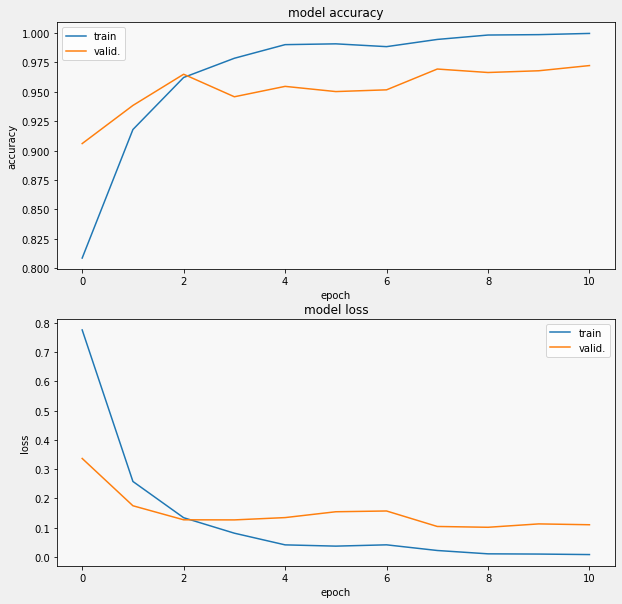

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

## Predictions

In [ ]:
# a couple of images to test predictions too
some_flowers, some_labels = dataset_to_numpy_util(validation_dataset, 160)

10/10 [==============================] - 7s 28ms/step - loss: 0.1023 - accuracy: 0.9688
['roses', 'daisy', 'sunflowers', 'tulips', 'tulips', 'sunflowers', 'dandelion', 'tulips', 'dandelion', 'tulips', 'dandelion', 'daisy', 'daisy', 'dandelion', 'dandelion', 'roses', 'dandelion', 'sunflowers', 'roses', 'sunflowers', 'roses', 'dandelion', 'daisy', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'roses', 'sunflowers', 'tulips', 'tulips', 'tulips', 'sunflowers', 'roses', 'dandelion', 'roses', 'dandelion', 'dandelion', 'dandelion', 'roses', 'tulips', 'tulips', 'tulips', 'roses', 'daisy', 'dandelion', 'daisy', 'sunflowers', 'daisy', 'daisy', 'tulips', 'tulips', 'tulips', 'dandelion', 'sunflowers', 'roses', 'sunflowers', 'dandelion', 'tulips', 'daisy', 'daisy', 'roses', 'dandelion', 'tulips', 'tulips', 'sunflowers', 'sunflowers', 'daisy', 'tulips', 'sunflowers', 'dandelion', 'daisy', 'sunflowers', 'dandelion', 'roses', 'dandelion', 'daisy', 'dandelion', 'daisy', 'sunflowers', 'sunflowers

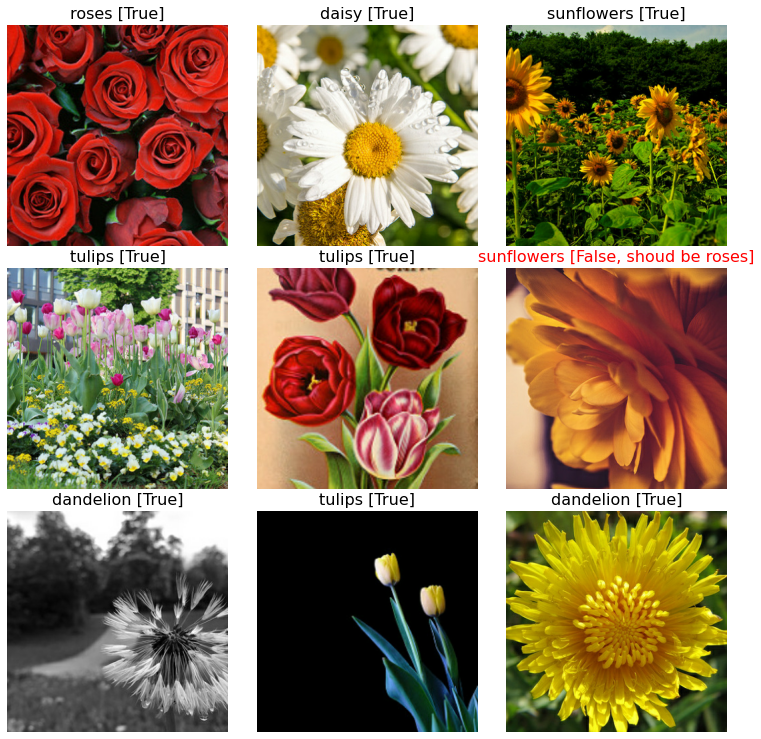

In [ ]:
# randomize the input so that you can execute multiple times to change results
permutation = np.random.permutation(8*20)
some_flowers, some_labels = (some_flowers[permutation], some_labels[permutation])

predictions = model.predict(some_flowers, batch_size=16)
evaluations = model.evaluate(some_flowers, some_labels, batch_size=16)
  
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)

display_9_images_with_predictions(some_flowers, predictions, some_labels)

## Save the model

In [ ]:
model.save('model.h5')

## Reload the model

10/10 [==============================] - 7s 625ms/step - loss: 0.1045 - accuracy: 0.9750
['roses', 'daisy', 'sunflowers', 'tulips', 'tulips', 'roses', 'dandelion', 'tulips', 'dandelion', 'tulips', 'dandelion', 'daisy', 'daisy', 'dandelion', 'dandelion', 'roses', 'dandelion', 'sunflowers', 'roses', 'sunflowers', 'roses', 'dandelion', 'daisy', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'roses', 'sunflowers', 'tulips', 'tulips', 'tulips', 'sunflowers', 'roses', 'dandelion', 'roses', 'dandelion', 'dandelion', 'dandelion', 'roses', 'tulips', 'tulips', 'tulips', 'roses', 'daisy', 'dandelion', 'daisy', 'sunflowers', 'daisy', 'daisy', 'tulips', 'tulips', 'tulips', 'dandelion', 'sunflowers', 'roses', 'sunflowers', 'dandelion', 'tulips', 'daisy', 'daisy', 'roses', 'dandelion', 'tulips', 'tulips', 'sunflowers', 'sunflowers', 'daisy', 'tulips', 'sunflowers', 'dandelion', 'daisy', 'sunflowers', 'dandelion', 'roses', 'dandelion', 'daisy', 'dandelion', 'daisy', 'sunflowers', 'sunflowers', '

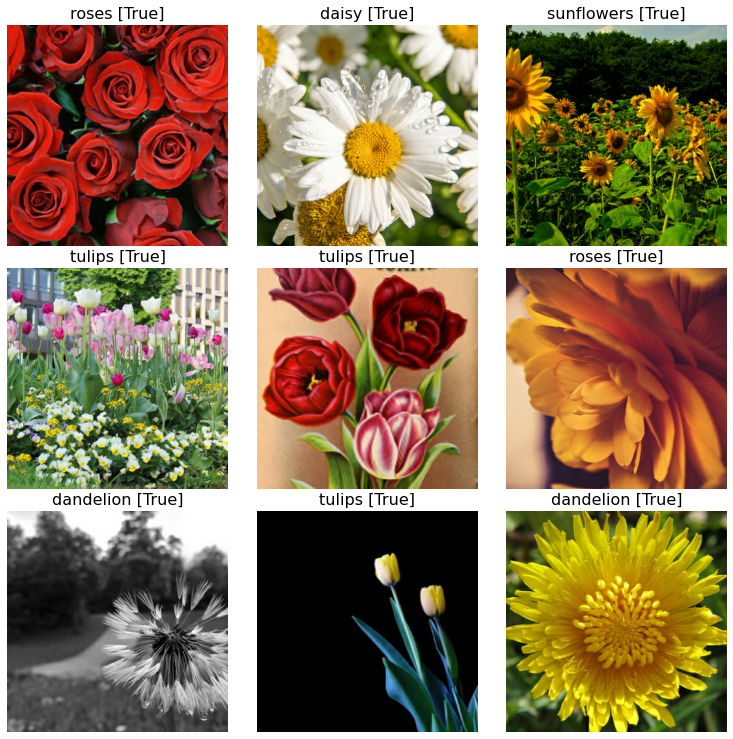

In [ ]:
reload_model = tf.keras.models.load_model('model.h5')

predictions = reload_model.predict(some_flowers, batch_size=16)
evaluations = reload_model.evaluate(some_flowers, some_labels, batch_size=16)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())
print('[val_loss, val_acc]', evaluations)
display_9_images_with_predictions(some_flowers, predictions, some_labels)